# 2. CNNs en Google Street View 

** 2.0 Importación de módulos necesarios **

In [209]:
import scipy.io as sio
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad, Adam
from keras import backend
from sklearn.metrics import confusion_matrix
import math
import random
import matplotlib.pyplot as plt

**2.1 Construcción de conjuntos de datos**

A partir de los archivos disponibles en formato Matlab, se construyen los conjuntos de entrenamiento y de prueba, separando los atributos predictores del atributo a predecir en primer lugar, para luego almacenarlos en matrices.

In [163]:
# Se cargan datos de entrenamiento
train_data = sio.loadmat('train_32x32.mat')
# Se cargan datos de prueba
test_data = sio.loadmat('test_32x32.mat')

# Se crea conjunto de entrenamiento con atributos predictores
X_train = train_data['X'].T.astype('float32')
# Se crea conjunto de entrenamiento con atributo a predecir
y_train = train_data['y'] - 1

# Se crea conjunto de prueba con atributos predictores
X_test = test_data['X'].T.astype('float32')
# Se crea conjunto de prueba con atributo a predecir
y_test = test_data['y'] - 1

A continuación, se determinan las dimensiones de las imágenes.

In [164]:
# Se determinan dimensiones y cantidad de ejemplos en conjunto de entrenamiento
n_channels = X_train.shape[1]
n_rows = X_train.shape[2]
n_cols = X_train.shape[3]
X_train.shape

(73257, 3, 32, 32)

In [165]:
# Se determinan dimensiones y cantidad de ejemplos en conjunto de prueba
X_test.shape

(26032, 3, 32, 32)

Los comandos anteriores muestran que se está trabajando con imágenes de 3 canales de 32 x 32. Además, el conjunto de entrenamiento está constituído por 73.257 ejemplos, mientras que el conjunto de pruebas está integrado por 26.032 ejemplos.

Por otra parte, el siguiente comando permite determinar la cantidad de clases diferentes que existen en el problema.

In [166]:
# Se obtiene número de clases del problema
n_classes = len(np.unique(y_train))
print n_classes

10


Esto es, existen 10 clases diferentes en el problema, cada una asociada a un dígito.

Además, se muestra la cantidad de ejemplos existentes por categoría para cada uno de los conjuntos de datos.

In [167]:
print 'Cantidad de ejemplos por categoría en conjunto de entrenamiento\n'
for i in range(n_classes):
    print 'Dígito', i, ':', len(np.where(y_train == i)[0]), 'ejemplos'

print('\n')
    
print 'Cantidad de ejemplos por categoría en conjunto de pruebas\n'
for i in range(n_classes):
    print 'Dígito', i, ':', len(np.where(y_test == i)[0]), 'ejemplos'

Cantidad de ejemplos por categoría en conjunto de entrenamiento

Dígito 0 : 13861 ejemplos
Dígito 1 : 10585 ejemplos
Dígito 2 : 8497 ejemplos
Dígito 3 : 7458 ejemplos
Dígito 4 : 6882 ejemplos
Dígito 5 : 5727 ejemplos
Dígito 6 : 5595 ejemplos
Dígito 7 : 5045 ejemplos
Dígito 8 : 4659 ejemplos
Dígito 9 : 4948 ejemplos


Cantidad de ejemplos por categoría en conjunto de pruebas

Dígito 0 : 5099 ejemplos
Dígito 1 : 4149 ejemplos
Dígito 2 : 2882 ejemplos
Dígito 3 : 2523 ejemplos
Dígito 4 : 2384 ejemplos
Dígito 5 : 1977 ejemplos
Dígito 6 : 2019 ejemplos
Dígito 7 : 1660 ejemplos
Dígito 8 : 1595 ejemplos
Dígito 9 : 1744 ejemplos


Finalmente, se visualizan 10 imágenes: 5 del conjunto de entrenamiento y 5 del conjunto de pruebas, elegidas de forma totalmente aleatoria.

Imágenes conjunto de entrenamiento


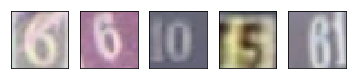

Imágenes conjunto de prueba


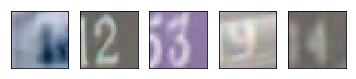

In [168]:
print "Imágenes conjunto de entrenamiento"

# Se seleccionan 5 imágenes de forma aleatoria a partir del conjunto de entrenamiento
train_images = random.sample(X_train, 5)

# Se grafican imágenes
for i in range(0, len(train_images)):      
    ax = plt.subplot(2, 5, 1 + i)
    im = train_images[i].reshape(3 ,32, 32).transpose(2, 1, 0)
    plt.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.show()

print "Imágenes conjunto de prueba"

# Se seleccionan 5 imágenes de forma aleatoria a partir del conjunto de prueba
test_images = random.sample(X_test, 5)

# Se grafican imágenes
for i in range(0, len(test_images)):      
    ax = plt.subplot(2, 5, 1 + i)
    im = test_images[i].reshape(3 ,32, 32).transpose(2, 1, 0)
    plt.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.show()

** 2.2 Normalización de datos **

Ya construídos los conjuntos de datos necesarios, se procede a normalizar las imágenes, para lo cual se dividen las intensidades de pixel de cada uno de dichos conjuntos por 255, que corresponde al máximo valor posible que un pixel puede tener. De esta manera, cada imágen será manejada computacionalmente como una matriz de números entre 0 y 1.

In [159]:
# Se dividen las intensidades de pixel por la intensidad máxima en ambos conjuntos de datos
X_train /= 255
X_test /= 255

Además, los vectores que almacenan las clases del problema son transformados en matrices categóricas con el fin de poder computar el error asociado a cada ejemplo en cada unas de las fases del proceso de entrenamiento.

In [169]:
# Vectores que contienen atributos a predecir son transformados en matrices categóricas
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

En este punto, también es conveniente generar un conjunto de validación para la comparación de diferentes arquitecturas en las siguientes secciones. Para esto, se extraerá aproximádamente el 20% final de los registros (14.651 registros) del conjunto de entrenamiento para construir el conjunto de validación, quedando el 80% restante como conjunto de entrenamiento (58.606 registros).

In [10]:
# Se construye conjunto de validación y posteriormente se reestructura conjunto de entrenamiento
X_val = X_train[int(math.ceil(0.8 * X_train.shape[0])) : , :, :, :]
Y_val = Y_train[int(math.ceil(0.8 * Y_train.shape[0])) :]
X_train = X_train[: int(math.ceil(0.8 * X_train.shape[0])), :, :, :]
Y_train = Y_train[: int(math.ceil(0.8 * Y_train.shape[0])), :]

** 2.3 Construcción de modelo clasificador **

En esta sección, se construye un modelo clasificador por medio del entrenamiento de una red convolucional. Su arquitectura base es *C* X *P* X *C* X *P* X *F* X *F*. Las capas de la red poseen las características que se detallan a continuación:

- La primera capa convolucional utiliza 16 filtros de dimensiones 5 x 5.
- La segunda capa convolucional utiliza 512 filtros de dimensiones 7 x 7.
- Ambas capas convolucionales son de tipo 2D.
- Entre cada una de las capas convolucionales se sitúa una capa de tipo max pooling (capa de reducción), las que escalan las dimensiones del input recibido en un factor de 2.
- La capa densa está compuesta por 20 neuronas.
- Entre la última capa de reducción y la capa densa se sitúa una capa de tipo flatten para la generación del vector de características a ser procesado por la capa densa.
- Tanto en las capas convolucionales como en la capa densa se utiliza la función de activación relu. 
- La capa de salida posee 10 neuronas y en ella se aplica la función de activación softmax.

El código utilizado para implementar la red previamente descrita es mostrado a continuación:

In [170]:
# Definición de arquitectura convolucional
# Se crea modelo vacío
model = Sequential()
# Se añade primera capa convolucional
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción
model.add(MaxPooling2D(pool_size=(2,2)))
# Se introduce segunda capa convolucional
model.add(Conv2D(512, (7, 7), padding='same', activation='relu'))
# Se añade segunda capa de reducción
model.add(MaxPooling2D(pool_size=(2,2)))
# Se agrega capa de tipo flatten
model.add(Flatten())
# Se introduce capa densa
model.add(Dense(20, activation='relu'))
# Se añade capa de salida
model.add(Dense(n_classes, activation='softmax'))

Ya definido el modelo con que se trabajará, es interesante observar como las dimensiones de un input determinado cambian a medida que este es procesado por cada una de las capas de la red. A continuación, se muestra una tabla resumen en la que, por cada capa, se específican las dimensiones del output producido y así como la cantidad de parámetros que el modelo posee.

In [25]:
# Se obtiene información acerca del modelo definido
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 512)       401920    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                655380    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total para

Se sabe que, en este problema, los inputs originales poseen dimensiones (número de filas de la imágen, número de columnas de la imágen, número de canales de la imágen). Específicamente, cada imágen del dataset con que se está trabajando posee dimensiones (32, 32, 3). Luego, se tiene, por ejemplo, que después de ser procesadas por la primera capa convolucional, las imágenes aumentan su número de canales de 3 a 16. Por otro lado, la primera capa de reducción reduce a la mitad tanto el número de filas como de columnas de la imágen, manteniendo el número de canales anterior. Otro caso notable es lo que ocurre con la capa de tipo flatten, la que se encarga de "destruir" la estructura tridimensional de la imágen, convirtiendo a cada una de ellas en un vector de tamaño número de filas x número de columnas x número de canales, con el fin de que puedan ser procesadas de forma adecuada por la capa densa. Se observa, además, que el modelo posee un total de 1.058.726 parámetros.

Ahora, se procede a entrenar el modelo previamente definido. Considerando que se está tratando un problema donde las clases son mutuamente excluyentes y además existen más de 2 clases, lo más apropiado es usar la función de pérdida *categorical crossentropy*. Se utilizará el método de entrenamiento *adagrad*, con el fin de adaptar la tasa de aprendizaje en cada iteración de entrenamiento. Se usará una tasa de aprendizaje inicial de 1e-08, batches de tamaño 1280 y 10 epochs.

In [26]:
X_train_ = X_train.reshape((X_train.shape[0], n_rows, n_cols, n_channels))
# X_val_ = X_val.reshape((X_val.shape[0], n_rows, n_cols, n_channels))
X_test_ = X_test.reshape((X_test.shape[0], n_rows, n_cols, n_channels))

# Se definen la función de pérdida a utilizar y el método de entrenamiento
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
# Se entrena modelo
model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_test_, Y_test))

Train on 73257 samples, validate on 26032 samples
Epoch 1/10
73257/73257 [==============================] - 890s - loss: 2.1732 - acc: 0.2731 - val_loss: 1.6987 - val_acc: 0.4429
Epoch 2/10
73257/73257 [==============================] - 896s - loss: 1.4581 - acc: 0.5166 - val_loss: 1.2225 - val_acc: 0.6200
Epoch 3/10
73257/73257 [==============================] - 900s - loss: 0.9899 - acc: 0.6881 - val_loss: 0.9613 - val_acc: 0.6925
Epoch 4/10
73257/73257 [==============================] - 907s - loss: 0.7722 - acc: 0.7646 - val_loss: 0.7946 - val_acc: 0.7591
Epoch 5/10
73257/73257 [==============================] - 911s - loss: 0.6728 - acc: 0.7970 - val_loss: 0.7058 - val_acc: 0.7934
Epoch 6/10
20736/73257 [=======>......................] - ETA: 606s - loss: 0.6181 - acc: 0.8147

KeyboardInterrupt: 

Se observa que la precisión de validación alcanzada es un de ??,??%. A continuación, se evalúa el modelo construído sobre el conjunto de pruebas.

In [ ]:
# Se evalúa modelo construído sobre conjunto de pruebas
model.evaluate(X_test_, Y_test)

Luego la precisión obtenida sobre el conjunto de pruebas es de un ??,?% , inferior/superior a la precisión *state-of-the-art*, que es de un 94,28%.

**2.4 Modificando el tamaño de los filtros**

En esta sección, se evalúan los efectos de modificar tanto el tamaño de los filtros utilizados en las capas convolucionales como el factor de reducción de las capas de tipo pooling. Especificamente, se desea saber como tales modificaciones benefician o bien perjudican la precisión obtenida sobre el conjunto de pruebas.   

**2.4.1 Primer caso**

En primer lugar, se experimentará utilizando filtros de tamaño 5 x 5 en cada capa convolucional, por lo que, en la primera de estas, el tamaño de los filtros se mantiene, mientras que en la segunda, se reduce en dos unidades. También, el factor de reducción presente en las capas de pooling será disminuído a 2, esto es, los inputs recibidos por estas capas serán reducidos a la mitad en cada dimensión.

In [97]:
model = Sequential()
# Se añade primera capa convolucional, manteniendo constante el tamaño de los filtros
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo factor de pooling a 2 en cada dimensión
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior, reduciendo el tamaño de los filtros en dos unidades
model.add(Conv2D(512, (5, 5), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model.add(Flatten())
# Se introduce capa densa
model.add(Dense(20, activation='relu'))
# Se añade capa de salida
model.add(Dense(n_classes, activation='softmax'))

Ya definido este nuevo modelo, se procede a entrenarlo.

In [98]:
# Se definen la función de pérdida a utilizar y el método de entrenamiento
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
# Se entrena modelo
case_one_history = model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_test_, Y_test))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
28160/58606 [=============>................] - ETA: 284s - loss: 2.6811 - acc: 0.1824

KeyboardInterrupt: 

Luego, se evalúa el modelo sobre el conjunto de pruebas.

In [ ]:
model.evaluate(X_test_, Y_test)

Se observa se obtiene una precisión del ??,?% sobre el conjunto de prueba, siendo mayor/menor a la precisión obtenida por la arquitectura definida originalmente.

**2.4.2 Segundo caso **

Ahora, se estudiará el efecto de duplicar el factor de reducción utilizado en la sección anterior, esto es, usando un *pool size* de 4 x 4 en cada capa de pooling. Además, el tamaño de los filtros se mantendrá en 5 x 5 para cada capa convolucional.

In [95]:
model = Sequential()
# Se añade primera capa convolucional, manteniendo constante el tamaño de los filtros
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, aumentando factor de pooling a 4 en cada dimensión
model.add(MaxPooling2D(pool_size=(4, 4)))
# Se introduce segunda capa convolucional, idéntica a la anterior
model.add(Conv2D(512, (5, 5), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model.add(MaxPooling2D(pool_size=(4, 4)))
# Se agrega capa de tipo flatten
model.add(Flatten())
# Se introduce capa densa
model.add(Dense(20, activation='relu'))
# Se añade capa de salida
model.add(Dense(n_classes, activation='softmax'))

Así, se procede a entrenar este modelo.

In [96]:
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
case_two_history = model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_test_, Y_test))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 202s - loss: 2.3455 - acc: 0.1862 - val_loss: 2.2374 - val_acc: 0.1875
Epoch 2/10
29184/58606 [=============>................] - ETA: 97s - loss: 2.2351 - acc: 0.1918

KeyboardInterrupt: 

Ya entrenado el modelo, este es evaluado sobre el conjunto de pruebas.

In [ ]:
model.evaluate(X_test_, Y_test)

En consecuencia, la nueva precisión de prueba que se obtiene es de un ??,?%, mejorando/empeorando respecto a la arquitectura original, y/pero aumentando/disminuyendo respecto a la precisión obtenida en la sección 2.4.1.

**2.4.3 Tercer caso**

Finalmente, se analizará el efecto de aumentar considerablemente el tamaño de los filtros utilizados en las capas convolucionales, siendo sus tamaños de 9 x 9. Además, el factor de reducción en las capas de pooling se reducirá nuevamente a 2 x 2.

In [ ]:
model = Sequential()
# Se añade primera capa convolucional, aumentando tamaño de los filtros a 9 en cada dimensión
model.add(Conv2D(16, (9, 9), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo el factor de pooling a 2 en cada dimensión
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior
model.add(Conv2D(512, (9, 9), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model.add(Flatten())
# Se introduce capa densa
model.add(Dense(20, activation='relu'))
# Se añade capa de salida
model.add(Dense(n_classes, activation='softmax'))

Se procede a entrenar el modelo definido.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
case_three_history = model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_test_, Y_test))

Con el modelo entrenado, se procede a determinar la precisión de prueba.

In [ ]:
model.evaluate(X_test_, Y_test)

Se observa, entonces, que la nueva precisión de prueba es de un ??,?%, mejorando/empeorando respecto a la arquitectura original, y/pero aumentando/disminuyendo respecto a la precisiones anteriores.

En este punto, resulta interesante comparar la evolución del error de entrenamiento en función del número de epochs para cada uno de los tres casos estudiados en esta sección.

In [ ]:
plt.plot(case_one_history.history['acc'])
plt.plot(case_two_history.history['acc'])
plt.plot(case_three_history.history['acc'])
plt.title('Comparación de precision de entrenamiento')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Caso 1', 'Caso 2', 'Caso 3'], loc='upper left')
plt.show()

El gráfico anterior da cuenta de que ...

**2.4.4 Resumen**

En la tabla que se muestra a continuación, se resumen los resultados obtenidos en las sub-secciones anteriores.

**2.5 Modificando la cantidad de filtros**

En esta sección, se experimenta modificando la cantidad de filtros utilizados en las capas convolucionales, buscando conocer los efectos que estas medidas tienen tanto sobre el tiempo de entrenamiento como sobre el error de pruebas. Dados los resultados de la sección 2.4, el tamaño de los filtros de las capas convolucionales será de 5 x 5, mientras que el *pool size* será de 2 x 2.

**2.5.1 Primer caso: Disminuyendo la cantidad de filtros**

Se estudia el efecto de reducir la cantidad de filtros convolucionales a la mitad con respecto a la arquitectura original, esto es, 8 filtros en la primera y 256 en la segunda. 

In [99]:
model = Sequential()
# Se añade primera capa convolucional, manteniendo constante el tamaño de los filtros
model.add(Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo factor de pooling a 2 en cada dimensión
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior, reduciendo el tamaño de los filtros en dos unidades
model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model.add(Flatten())
# Se introduce capa densa
model.add(Dense(20, activation='relu'))
# Se añade capa de salida
model.add(Dense(n_classes, activation='softmax'))

Luego, el modelo es entrenado.

In [100]:
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
case_one_history = model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_test_, Y_test))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
 6144/58606 [==>...........................] - ETA: 259s - loss: 12.8528 - acc: 0.1390

KeyboardInterrupt: 

Estando el modelo ya entrenado, se evalúa su rendimiento sobre el conjunto de pruebas.

In [ ]:
model.evaluate(X_test_, Y_test)

Se observa que la precisión obtenida sobre el conjunto de prueba es de un ??,?%, siendo mayor/menor a la precisión obtenida por la arquitectura original.

**2.5.2 Segundo Caso: Aumentando la cantidad de filtros**

Se analiza el efecto de duplicar la cantidad de filtros usados en las capas convolucionales, es decir, se utilizan 32 filtros, en vez de 16 en la primera, y 1024 en la segunda, en vez de 512.

In [ ]:
model = Sequential()
# Se añade primera capa convolucional, manteniendo constante el tamaño de los filtros
model.add(Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo factor de pooling a 2 en cada dimensión
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior, reduciendo el tamaño de los filtros en dos unidades
model.add(Conv2D(1024, (5, 5), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model.add(Flatten())
# Se introduce capa densa
model.add(Dense(20, activation='relu'))
# Se añade capa de salida
model.add(Dense(n_classes, activation='softmax'))

Definido el modelo, este es entrenado.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
case_two_history = model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_test_, Y_test))

A continuación, se evalúa el modelo sobre el conjunto de pruebas.

In [ ]:
model.evaluate(X_test_, Y_test)

El resultado anterior implica que la precisión de prueba conseguida es de un ??,?%, mejorando/empeorando en comparación arquitectura original, y/pero aumentando/disminuyendo respecto a la precisión obtenida en la sección 2.5.1.

De forma análoga a la sección 2.4, resulta interesante comparar la evolución del error de entrenamiento en función del número de epochs para los dos casos estudiados en esta sección.

In [ ]:
plt.plot(case_one_history.history['acc'])
plt.plot(case_two_history.history['acc'])
plt.title('Comparación de precision de entrenamiento')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Caso 1', 'Caso 2'], loc='upper left')
plt.show()

El gráfico construído muestra que ...

** 2.5.3 Resumen **

En la siguiente tabla, se resumen los resultados conseguidos en las sub-secciones previas.

**2.6 Modificando la red**

En la siguiente sección, se desea introducir posibles mejoras en el rendimiento de la red sobre el conjunto de pruebas.

Teóricamente, se sabe que para construir un buen modelo, es necesario que la cantidad de ejemplos utilizados para su entrenamiento sea proporcional al número de parámetros que posee. En este contexto, tales condiciones no se cumplen, tomando en cuenta que el número de parámetros de las arquitecturas estudiadas es de un 1.000.000, mientras que la cantidad de ejemplos usados para el entrenamiento es de alredor de 60.000. Sin embargo, el aumentar significativamente el volumen de dichos ejemplos puede llevar a que el entrenamiento sea inviable si no se cuenta con los recursos computacionales apropiados. Luego, una alternativa que puede ayudar a remediar esta situación es regularizar el modelo por medio de *dropout*, esto es, desactivando un porcentaje determinado de las neuronas de las capas convolucionales en cada epoch.

También, se aumentará el número de neuronas en la capa densa, esperando que esto ayude a complementar el efecto de regularización. Dicho aumentó llevará a que la capa esté constituida por 100 neuronas.

En el siguiente código, se introducen las modificaciones señaladas. Para la primera capa convolucional, se utilizarán 16 filtros de dimensiones 5 x 5. Para la segunda, 512 filtros de tamaño 5 x 5. Por último, las capas de *max pooling* tendrán asociado un *pool size* de 2 x 2. El parámetro *dropout* será de un 25% para la primera capa convolucional y la capa densa, mientras que será de un 50% para la segunda capa convolucional.

In [101]:
model = Sequential()
# Se añade primera capa convolucional
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce dropout
model.add(Dropout(0.25))
# Se introduce segunda capa convolucional
model.add(Conv2D(512, (5, 5), padding='same', activation='relu'))
# Se añade segunda capa de reducción
model.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce dropout
model.add(Dropout(0.5))
# Se agrega capa de tipo flatten
model.add(Flatten())
# Se introduce capa densa, aumentando a 100 la cantidad de neuronas
model.add(Dense(100, activation='relu'))
# Se introduce dropout en capa densa
model.add(Dropout(0.25))
# Se añade capa de salida
model.add(Dense(n_classes, activation='softmax'))

En el siguiente esquema, se muestra en detalle los cambios experimentados por las dimensiones de un input determinado, junto con la cantidad de parámetros que este nuevo modelo posee.

In [ ]:
# Se muestran nuevas características de modelo al agregar dropout y más neuronas a la capa densa
model.summary()

Se puede ver que ahora ...

Así, se continúa con el entrenamiento del modelo.

In [108]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_test_, Y_test))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
 1024/58606 [..............................] - ETA: 627s - loss: 12.9543 - acc: 0.1963

KeyboardInterrupt: 

Luego, se evalúa el modelo sobre el conjunto de pruebas.

In [ ]:
model.evaluate(X_test_, Y_test)

Con esto, se aprecia que la precisión de prueba que se obtiene es de un ??,?%, mejorando/empeorando en comparación con la  arquitectura original. Así (no) tiene sentido introducir las modificaciones que se describieron en los párrafos previos.

**2.7 Visualización de pesos y efecto de filtros en primera capa convolucional**

En esta sección, se visualizan los pesos asociados a la primera capa convolucional del modelo definido en la sección 2.6. Se ha escogido dicho modelo dado a que fue el que logró obtener la mejor precisión sobre el conjunto de pruebas en comparación con los modelos previamente implementados.  

In [28]:
# Se obtienen pesos de primera capa convolucional del modelo 2.6
weights = model.layers[0].get_weights()

A continuación, se obtiene tanto la cantidad de filtros utilizados como las dimensiones de la matriz de pesos de cada uno de ellos.

In [29]:
# Se obtiene el número de filtros y las dimensiones de la matriz de pesos
weights[0].shape

(5, 5, 3, 16)

Luego, la primera capa convolucional posee ?? filtros y las dimensiones de la matriz de pesos asociada a cada filtro posee dimensiones ? x ?, las que son utilizadas en cada uno de los ? canales del input recibido.

A modo de ejemplo, se muestra matriz de pesos del primer filtro de la capa. Notar que existe una matriz diferente por cada uno de los canales del input recibido.

In [50]:
# Se muestra matriz de pesos de primer filtro de la capa convolucional
weights[0].T[0]

array([[[ 0.06615372, -0.00036563, -0.0307028 , -0.00054911,  0.11497077],
        [ 0.03400547, -0.0348995 , -0.05088709, -0.01618329,  0.01189419],
        [-0.06203185,  0.06904574, -0.02477074,  0.03481288, -0.07421578],
        [ 0.04913144, -0.00220171,  0.02490551, -0.04410044,  0.08087634],
        [ 0.08077955,  0.01831094,  0.04312797,  0.05315828, -0.06155473]],

       [[-0.10391471, -0.08270985, -0.07440285,  0.11442221, -0.05483063],
        [-0.01990045,  0.10880399, -0.11499698,  0.00292117, -0.0591929 ],
        [ 0.05069643,  0.03297641, -0.06930592,  0.03770806,  0.04111828],
        [-0.02330139,  0.08986996, -0.03310759, -0.09138342, -0.05486297],
        [-0.11611158,  0.05514577, -0.05985119,  0.0633671 , -0.07332732]],

       [[-0.10721993,  0.04443175,  0.01847619,  0.00329364, -0.02062938],
        [ 0.0530754 ,  0.10624516, -0.05842349, -0.07849637,  0.03334872],
        [ 0.10512989,  0.04888074,  0.08359171, -0.01388774, -0.06498303],
        [ 0.00438999,

Por otra parte, también interesa conocer el efecto que tienen los filtros de la capa sobre una imágen determinada. Para ello, primero se escoge de forma aleatoria una imágen del conjunto de entrenamiento y se muestra.

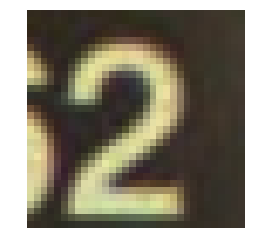

In [195]:
# Se escoge imágen de conjunto de entrenamiento

random.seed(21)
image = random.choice(X_train).reshape(n_channels, n_rows, n_cols).transpose(2, 1, 0)
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

En las siguientes figuras, se muestra el resultado de aplicar cada uno de los filtros de la primera capa convolucional sobre la imágen que acaba de ser mostrada. Cada uno de estos "resultados" es denominado *feature map* en la teoría y permite advertir las características que el filtro está aprendiendo a partir de la imágen.

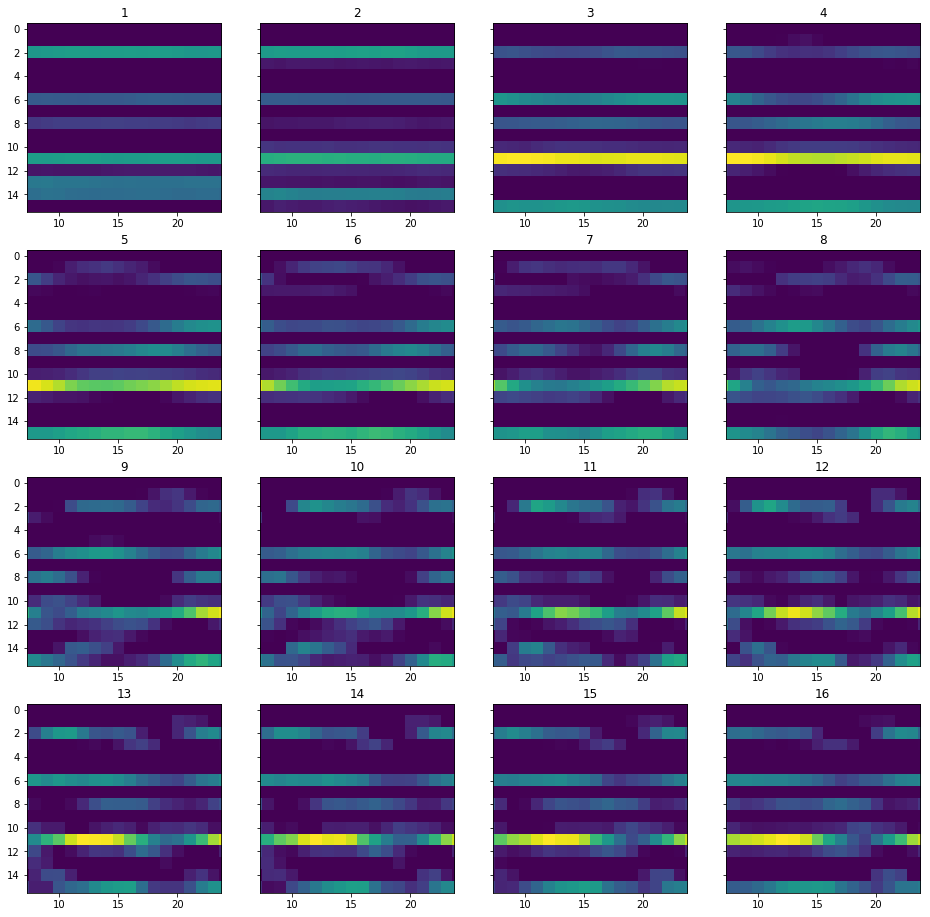

In [196]:
# Se obtiene feature map de cada filtro
filters_output_function = backend.function([model.layers[0].input], [model.layers[0].output])
filters_output = filters_output_function([np.array([image])])[0]

# Se muestra feature map de cada filtro
filters = filters_output[0]
f, ax = plt.subplots(4, 4, sharey=True, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        filter_number = 4 * i + j + 1
        ax[i][j].set_title(filter_number)
        ax[i][j].imshow(np.transpose(filters[filter_number - 1]))
plt.show()

De esta manera, se aprecia que ...

**2.8 ¿Tiende la red a confudir ciertos dígitos?**

Culminando el análisis de este problema, se busca determinar los pares de dígitos que la red tiende a confudir. Para ello, se procede a computar la matriz de confusión del modelo escogido. De esta forma, se tiene que el elemento ij de esta matriz corresponde a la cantidad de imágenes cuya clase real es i, pero el modelo predijo j como su clase.

In [210]:
# Se crea lista con la clase real de cada imágen perteneciente al conjunto de prueba
real_values = [y[0] for y in y_test]
# Se crea lista con la clase predicha para cada imágen por el modelo considerado
predicted_values = [y_[0] for y_ in model.predict(X_test_)]

# A partir de las listas anteriores, se computa la matriz de confusión del modelo
confusion_matrix(real_values, predicted_values)

KeyboardInterrupt: 

Observando la matriz de confusión, se tiene que ...